# **Data Augmentation using Albumentations**

To enhance the generalization capability of our model and address the challenge of limited dataset size, we apply advanced data augmentation techniques using the **Albumentations library**.  
These augmentations (random rotations, flips, brightness adjustments, zooms, and coarse dropout) artificially increase the diversity of the training data, simulating real-world variations such as different lighting, orientations, and partial occlusions.  

This approach helps reduce overfitting and ensures that our ResNet50 model learns robust features that generalize well to unseen data.


In [1]:
!pip show albumentations


Name: albumentations
Version: 2.0.8
Summary: Fast, flexible, and advanced augmentation library for deep learning, computer vision, and medical imaging. Albumentations offers a wide range of transformations for both 2D (images, masks, bboxes, keypoints) and 3D (volumes, volumetric masks, keypoints) data, with optimized performance and seamless integration into ML workflows.
Home-page: https://albumentations.ai
Author: Vladimir Iglovikov
Author-email: 
License: MIT License

Copyright (c) 2017 Vladimir Iglovikov, Alexander Buslaev, Alexander Parinov,

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above c

In [19]:
import albumentations as A

alb_aug = A.Compose([
    A.Resize(224, 224),  # All images resized for ResNet
    A.HorizontalFlip(p=0.5),  # Faces flipped horizontally
    A.Rotate(limit=5, p=0.3),  # Very slight rotation (±5°)
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=0, p=0.2),
    A.Normalize()  # Normalize for ResNet50
])




#    **Data Cleaning**

In [20]:
import os
import cv2

def clean_corrupted_images(folder):
    removed = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            removed.append(img_name)
            os.remove(img_path)  # Delete corrupted image
    return removed

# Clean both classes (train, val, test)
def clean_all_classes(base_dir):
    total_removed = 0
    for split in ["train", "val", "test"]:
        for class_name in ["healthy child face", "malnourished child face"]:
            folder = os.path.join(base_dir, split, class_name)
            removed = clean_corrupted_images(folder)
            total_removed += len(removed)
            if removed:
                print(f"Removed {len(removed)} corrupted images from {folder}")
    if total_removed == 0:
        print("No corrupted images found.")
    else:
        print(f"Total removed corrupted images: {total_removed}")

# Run cleanup
clean_all_classes('resnet_dataset')


Removed 1 corrupted images from resnet_dataset\train\malnourished child face


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'resnet_dataset\\val\\healthy child face'

In [4]:
def count_images(base_dir):
    for split in ["train", "val", "test"]:
        for class_name in ["healthy child face", "malnourished child face"]:
            folder = os.path.join(base_dir, split, class_name)
            count = len([img for img in os.listdir(folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{split}/{class_name}: {count} images")

count_images('resnet_dataset')


train/healthy child face: 344 images
train/malnourished child face: 325 images
val/healthy child face: 73 images
val/malnourished child face: 71 images
test/healthy child face: 75 images
test/malnourished child face: 74 images


# **Dataset Visualization**

To verify data quality and class distribution, we randomly visualize images from both **Healthy** and **Malnourished** classes.  
This step ensures that the dataset is correctly structured and helps in identifying any anomalies or irrelevant images before training.
 




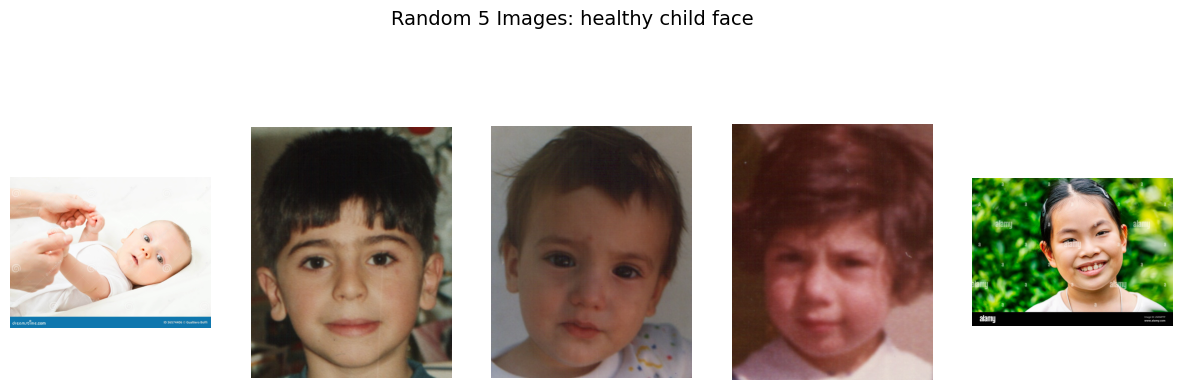

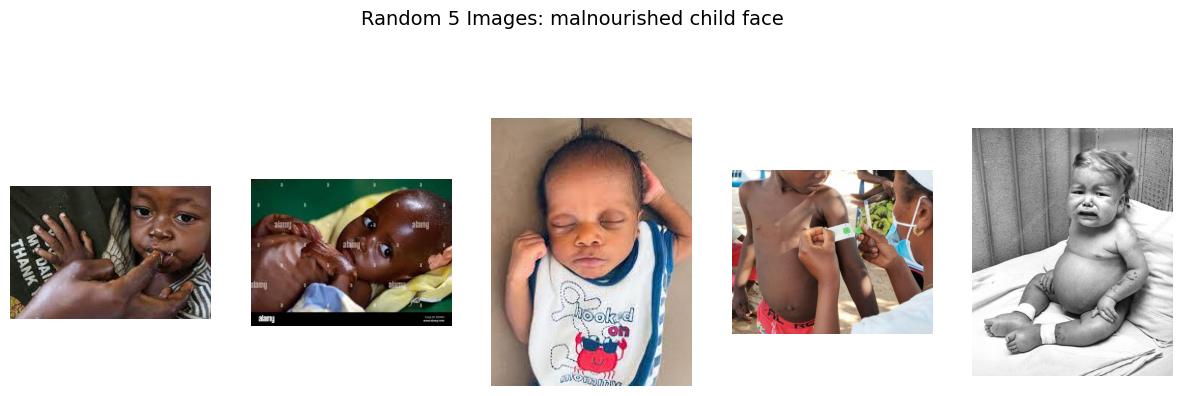

In [16]:
import os
import cv2
import matplotlib.pyplot as plt
import random

def show_random_images(dataset_path, class_name, n=5):
    class_folder = os.path.join(dataset_path, class_name)
    images = [img for img in os.listdir(class_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly pick n images
    random_images = random.sample(images, min(n, len(images)))

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")  # Hide axes and labels
    plt.suptitle(f"Random {n} Images: {class_name}", fontsize=14)
    plt.show()

# Show 5 random images from each class
show_random_images('resnet_dataset/train', 'healthy child face', n=5)
show_random_images('resnet_dataset/train', 'malnourished child face', n=5)



#                              **Data Augmentation using Albumentation** 


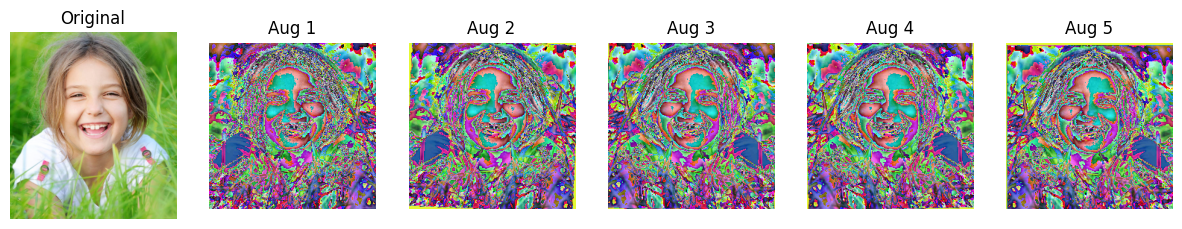

In [22]:
def visualize_safe_augmentations(dataset_path, class_name, n=5):
    class_folder = os.path.join(dataset_path, class_name)
    all_images = [img for img in os.listdir(class_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    img_name = random.choice(all_images)
    img_path = os.path.join(class_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, n+1, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    for i in range(n):
        augmented = alb_aug(image=img)['image']
        plt.subplot(1, n+1, i+2)
        plt.imshow((augmented * 255).astype('uint8'))
        plt.title(f"Aug {i+1}")
        plt.axis("off")

    plt.show()

# Example usage
visualize_safe_augmentations('resnet_dataset/train', 'healthy child face', n=5)



In [11]:

train_gen = AlbumentationsDataGenerator('resnet_dataset/train', batch_size=32, target_size=(224, 224), aug=alb_aug)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    'resnet_dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    'resnet_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 144 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


# ** DATA VISUALIZATION AFTER AUGMENTATIONS**